In [22]:
import os
import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

In [23]:
def process_experiment(root_dir):
    rows = []

    for name in os.listdir(root_dir):
        experiment_path = os.path.join(root_dir, name)
        if os.path.isdir(experiment_path):
            for seed_name in os.listdir(experiment_path):
                seed_path = os.path.join(experiment_path, seed_name)
                if os.path.isdir(seed_path):
                    row_data = process_subexperiment(
                        seed_path, os.path.basename(root_dir)
                    )
                    for data in row_data:
                        data["seed"] = seed_name
                        data["experiment_name"] = name
                    rows.extend(row_data)  

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df


def process_subexperiment(seed_folder_path, experiment_name):
    cfg_data = read_config(os.path.join(seed_folder_path, "cfg.yaml"), experiment_name)
    train_stats_file = find_train_stats_file(seed_folder_path)
    if train_stats_file:
        experiment_results = process_training_stats(
            train_stats_file, cfg_data
        )
        return experiment_results
    else:
        return []  # Return an empty list if no train stats file is found


def read_config(cfg_path, experiment_name):
    with open(cfg_path, "r") as file:
        config = yaml.safe_load(file)
        full_title = config.get("full_title", "")
        variable_part = remove_experiment_name(full_title, experiment_name)
        return parse_config_variables(variable_part)


def remove_experiment_name(full_title, experiment_name):
    to_remove = experiment_name + "_"
    return (
        full_title[len(to_remove) :].strip()
        if full_title.startswith(to_remove)
        else full_title
    )


def parse_config_variables(variable_str):
    variables = {}
    for part in variable_str.split(";"):
        if "=" in part:
            key, value = part.split("=", 1)
            variables[key.strip()] = value.strip()
    return variables


def find_train_stats_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith("_train_stats"):
            return os.path.join(folder_path, file)
    return None


def process_training_stats(train_stats_file, cfg_data):
    checkpoint = torch.load(train_stats_file)

    training_stats = checkpoint.get("training_stats", [])
    validation_stats = checkpoint.get("validation_stats", [])
    redo_stats = checkpoint.get("redo_scores", [])

    stats_records = process_stats(training_stats, cfg_data, "training") + process_stats(
        validation_stats, cfg_data, "validation"
    )

    # Combine stats records with redo scores
    combined_records = []
    for record in stats_records:
        combined_record = record.copy()  # Copy the stats record
        combined_records.append(combined_record)

    return combined_records


def process_stats(stats, cfg_data, stats_type):
    records = []
    for epoch_stats in stats:
        record = {"epoch_type": stats_type}
        record.update(flatten(epoch_stats))  # Flatten the epoch_stats if it's nested
        record.update(cfg_data)  # Add configuration data
        records.append(record)
    return records


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [24]:
experiment_sub_dir = "2025Mar15-155315_configs"
exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'optim.args_.lr', 'agent_params.args_.gamma', 'seed',
       'experiment_name'],
      dtype='object')

In [25]:
df

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,optim.args_.lr,agent_params.args_.gamma,seed,experiment_name
0,training,200000,-234.992762,-47.570700,-112.194555,-112.986061,19.300707,-160.295492,-42.182425,-85.664534,...,-1.485953,-1.030588,1.356286,48749.0,48.0,0 days 00:02:31.346051,0.01,0.99,0,0000_optim.args_.lr_0.01__agent_params.args_.g...
1,training,400000,-175.986942,-81.880769,-113.411284,-112.094043,13.425117,-129.206303,-67.472702,-87.467604,...,-3.155848,-2.406338,2.413327,50000.0,48.0,0 days 00:02:37.948950,0.01,0.99,0,0000_optim.args_.lr_0.01__agent_params.args_.g...
2,training,600000,-151.902732,-58.698101,-81.651156,-77.948098,14.522684,-113.798213,-50.018291,-66.693106,...,-3.376889,-2.374882,2.818809,50000.0,52.0,0 days 00:02:39.022351,0.01,0.99,0,0000_optim.args_.lr_0.01__agent_params.args_.g...
3,training,800000,-169.910093,-58.898348,-100.740763,-107.809203,23.082181,-123.751888,-50.148290,-77.940615,...,-3.649348,-2.697515,2.695905,50000.0,48.0,0 days 00:03:01.816713,0.01,0.99,0,0000_optim.args_.lr_0.01__agent_params.args_.g...
4,training,1000000,-158.094207,-89.356059,-114.802450,-113.614745,9.395698,-115.453926,-70.287218,-86.767135,...,-4.584213,-3.540669,3.053591,50000.0,52.0,0 days 00:03:14.047859,0.01,0.99,0,0000_optim.args_.lr_0.01__agent_params.args_.g...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,validation,4200000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-201.632051,-201.632051,-201.632051,...,-73.035461,-73.035461,0.000000,NaN,NaN,0 days 00:00:00.280953,0.1,0.99,1,0001_optim.args_.lr_0.1__agent_params.args_.ga...
196,validation,4400000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-201.632051,-201.632051,-201.632051,...,-73.675423,-73.675423,0.000000,NaN,NaN,0 days 00:00:00.287869,0.1,0.99,1,0001_optim.args_.lr_0.1__agent_params.args_.ga...
197,validation,4600000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-201.632051,-201.632051,-201.632051,...,-74.223240,-74.223221,0.000418,NaN,NaN,0 days 00:00:00.265500,0.1,0.99,1,0001_optim.args_.lr_0.1__agent_params.args_.ga...
198,validation,4800000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-201.632051,-201.632051,-201.632051,...,-74.754731,-74.754730,0.000022,NaN,NaN,0 days 00:00:00.252441,0.1,0.99,1,0001_optim.args_.lr_0.1__agent_params.args_.ga...


In [ ]:
# normalize rewards?

In [31]:
df[df['epoch_type'] == 'validation']

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,optim.args_.lr,agent_params.args_.gamma,seed,experiment_name
25,validation,200000,-62.526231,-62.526231,-62.526231,-62.526231,0.000000,-53.881087,-53.881087,-53.881087,...,-2.338461,-1.759644,1.809211,NaN,NaN,0 days 00:00:00.238732,0.01,0.99,0,0000_optim.args_.lr_0.01__agent_params.args_.g...
26,validation,400000,-62.526231,-62.526231,-62.526231,-62.526231,0.000000,-53.881087,-53.881087,-53.881087,...,-3.332497,-2.467129,2.661803,NaN,NaN,0 days 00:00:00.236294,0.01,0.99,0,0000_optim.args_.lr_0.01__agent_params.args_.g...
27,validation,600000,-54.572420,-54.572420,-54.572420,-54.572420,0.000000,-47.494475,-47.494475,-47.494475,...,-3.072175,-2.148714,2.569316,NaN,NaN,0 days 00:00:00.247767,0.01,0.99,0,0000_optim.args_.lr_0.01__agent_params.args_.g...
28,validation,800000,-85.841916,-85.770049,-85.784422,-85.770049,0.028747,-66.384381,-66.356953,-66.362439,...,-3.010172,-1.437478,2.493184,NaN,NaN,0 days 00:00:00.305974,0.01,0.99,0,0000_optim.args_.lr_0.01__agent_params.args_.g...
29,validation,1000000,-84.772514,-84.772514,-84.772514,-84.772514,0.000000,-65.898159,-65.898159,-65.898159,...,-3.729613,-2.106664,2.803802,NaN,NaN,0 days 00:00:00.296727,0.01,0.99,0,0000_optim.args_.lr_0.01__agent_params.args_.g...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,validation,4200000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-201.632051,-201.632051,-201.632051,...,-73.035461,-73.035461,0.000000,NaN,NaN,0 days 00:00:00.280953,0.1,0.99,1,0001_optim.args_.lr_0.1__agent_params.args_.ga...
196,validation,4400000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-201.632051,-201.632051,-201.632051,...,-73.675423,-73.675423,0.000000,NaN,NaN,0 days 00:00:00.287869,0.1,0.99,1,0001_optim.args_.lr_0.1__agent_params.args_.ga...
197,validation,4600000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-201.632051,-201.632051,-201.632051,...,-74.223240,-74.223221,0.000418,NaN,NaN,0 days 00:00:00.265500,0.1,0.99,1,0001_optim.args_.lr_0.1__agent_params.args_.ga...
198,validation,4800000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-201.632051,-201.632051,-201.632051,...,-74.754731,-74.754730,0.000022,NaN,NaN,0 days 00:00:00.252441,0.1,0.99,1,0001_optim.args_.lr_0.1__agent_params.args_.ga...


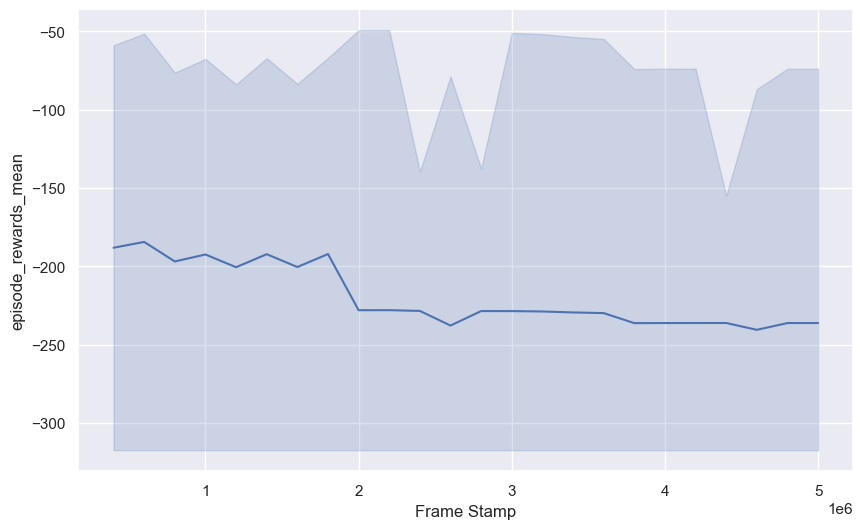

In [26]:
selected_metric = 'episode_rewards_mean'
# Filter for validation episodes
validation_df = df[df['epoch_type'] == 'validation']

# Get the unique sorted frame_stamp values
unique_frames = np.sort(validation_df['frame_stamp'].unique())
N = 1
# Get all frame_stamp values after the first N unique ones
filtered_frames = unique_frames[N:]

# Filter the DataFrame to only include rows with these frame_stamp values
filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric)
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.show()

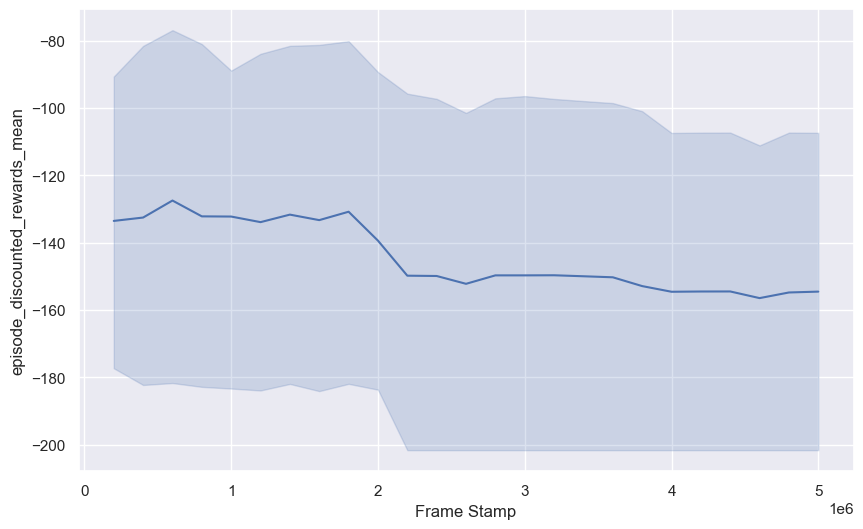

In [27]:

selected_metric = 'episode_discounted_rewards_mean'

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=df, x='frame_stamp', y=selected_metric)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [29]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name'
]
hyperparam_columns = [
   #    'optim.args_.eps', 
       'optim.args_.lr',
      #  'estimator.args_.lin_hidden_out_size', 
    #    'agent_params.args_.batch_size',
       'agent_params.args_.gamma',
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,optim.args_.lr,agent_params.args_.gamma
49,validation,5000000,NaN,100.0,NaN,NaN,0 days 00:00:00.257645,0,0000_optim.args_.lr_0.01__agent_params.args_.g...,0.01,0.99
99,validation,5000000,-73.832430,70.0,NaN,NaN,0 days 00:00:00.290405,1,0000_optim.args_.lr_0.01__agent_params.args_.g...,0.01,0.99
149,validation,5000000,-317.471927,100.0,NaN,NaN,0 days 00:00:00.254289,0,0001_optim.args_.lr_0.1__agent_params.args_.ga...,0.1,0.99
199,validation,5000000,-317.471927,100.0,NaN,NaN,0 days 00:00:00.280206,1,0001_optim.args_.lr_0.1__agent_params.args_.ga...,0.1,0.99


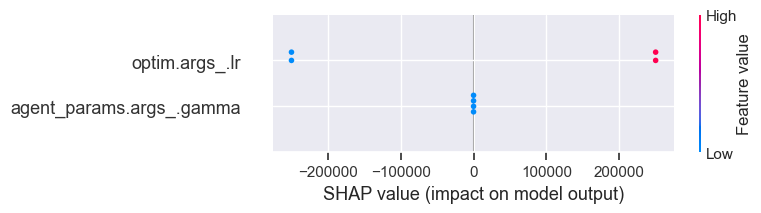

In [30]:
import shap
import xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(-1e6)

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)